In [1]:
import torch
from sklearn.metrics import accuracy_score
from transformers import BertConfig, BertTokenizer, BertModel
import torch.nn as nn
import os
import pandas as pd
from torch.utils.data import random_split, DataLoader, TensorDataset
from datasets import load_dataset, load_metric

/data/homezvol2/gautamb1/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class BertCustomHead(nn.Module):
    def __init__(self, config, num_classes, task_type='sequence_classification'):
        super(BertCustomHead, self).__init__()
        self.bert = BertModel(config)
        self.task_type = task_type

        self.heads = nn.ModuleDict({
            'sequence_classification': nn.Linear(config.hidden_size, num_classes),
            'token_classification': nn.Linear(config.hidden_size, num_classes),
            'multiple_choice': nn.Linear(config.hidden_size, 1),
            'summarization': nn.Linear(config.hidden_size, config.vocab_size)
        })

        self.loss_fns = {
            'sequence_classification': nn.CrossEntropyLoss(),
            'token_classification': nn.CrossEntropyLoss(),
            'multiple_choice': nn.BCEWithLogitsLoss(),
            'summarization': nn.CrossEntropyLoss(ignore_index=config.pad_token_id)
        }

        if task_type not in self.heads:
            raise ValueError("Invalid task type. Supported types: 'sequence_classification', 'token_classification', 'multiple_choice', 'summarization'")

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, decoder_input_ids=None):
        if self.task_type == 'summarization':
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            sequence_output = outputs.last_hidden_state
            logits = self.heads['summarization'](sequence_output)
            return logits
        else:
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            return self.heads[self.task_type](pooled_output)

In [3]:
import time
def evaluate_model_hf(model, data_loader, device='cpu'):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    start_time = time.time()
    with torch.no_grad():
        for idx, batch in enumerate(data_loader):
            if (idx%100 ==0):
                print(idx)
            inputs = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['label']
            inputs = inputs.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            logits = model(input_ids=inputs, attention_mask=attention_mask)
            preds = torch.argmax(logits, dim=-1)
            # print(preds)
            # print(labels)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    
    return accuracy, time.time()-start_time


In [4]:
def calcSparsity(model):
    zeros = 0
    elements = 0

    for _, param in model.named_parameters():

        zero_count = torch.sum(param==0.0).item()
        zeros += zero_count

        element_count = param.numel()
        elements += element_count

    if(elements == 0):
        return 0

    return zeros / elements


In [5]:
accuracy_all = {}
time_all = {}
actual_sparsity_all = {}
pruning_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for pruning_rate in pruning_rates:

    # Load configuration and tokenizer
    model_dir = "/pub/gautamb1/cs295/checkpoints/bert_prune_sst2_" + str(pruning_rate)
    if (pruning_rate == 0.0):
        model_dir = "/pub/gautamb1/cs295/checkpoints/bert_finetuned_sst2"
    config = BertConfig.from_pretrained(model_dir)
    tokenizer = BertTokenizer.from_pretrained(model_dir)
    
    num_classes = 2  
    task='sst2'
    model = BertCustomHead(config, num_classes, task_type='sequence_classification')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state_dict_path = os.path.join(model_dir, 'pytorch_model.bin')
    state_dict = torch.load(state_dict_path, map_location=device) #Dont map it to CPU if ur using a GPU!!!
    model.load_state_dict(state_dict)
    model.to(device)
    
    # Load dataset and tokenizer
    dataset = load_dataset("glue", task)
    metric = load_metric("glue", task, trust_remote_code=True)  # Use evaluate library in future
    
    # Preprocessing function
    def preprocess_function(examples):
        return tokenizer(examples['sentence'], padding='max_length', truncation=True)
    
    # Tokenize the dataset
    encoded_dataset = dataset.map(preprocess_function, batched=True)
    encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    
    # Prepare DataLoader
    batch_size = 16
    SST_validation_dataset = encoded_dataset['validation']
    SST_validation_dataloader = DataLoader(SST_validation_dataset, batch_size=batch_size)
    print(SST_validation_dataloader.dataset)
    actual_sparsity = calcSparsity(model)
    actual_sparsity_all[pruning_rate] = actual_sparsity
    
    accuracy, time_all[pruning_rate]  = evaluate_model_hf(model, SST_validation_dataloader, device)
    accuracy_all[pruning_rate] = accuracy
    print(f"Accuracy of the model: {accuracy:.4f}")

/tmp/gautamb1/31695175/ipykernel_134495/96490351.py:26: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("glue", task, trust_remote_code=True)  # Use evaluate library in future


Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 872
})
0
Accuracy of the model: 0.8108
Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 872
})
0
Accuracy of the model: 0.7729
Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 872
})
0
Accuracy of the model: 0.7511
Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 872
})
0
Accuracy of the model: 0.7087
Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 872
})
0
Accuracy of the model: 0.5562
Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 872
})
0
Accuracy of the model: 0.5057
Dataset({
    features: ['sentence', 'label', 'idx', 'input_ids'

In [6]:
import pickle
with open('sst2_attribution.pickle', 'wb') as handle:
    pickle.dump(accuracy_all, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [7]:
with open('sst2_attribution.pickle', 'rb') as handle:
    b = pickle.load(handle)

print(b)

{0.0: 0.8107798165137615, 0.1: 0.7729357798165137, 0.2: 0.7511467889908257, 0.3: 0.7087155963302753, 0.4: 0.5561926605504587, 0.5: 0.5057339449541285, 0.6: 0.4908256880733945, 0.7: 0.4908256880733945, 0.8: 0.4908256880733945, 0.9: 0.4908256880733945, 1.0: 0.5091743119266054}


In [ ]:
import matplotlib.pyplot as plt
plt.plot(pruning_rates[:10], list(accuracy_all.values())[:10])
plt.xlabel('Sparsity')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Sparsity (SST-2)')
plt.savefig("Accuracy v Pruning Sparsity (SST-2).png")

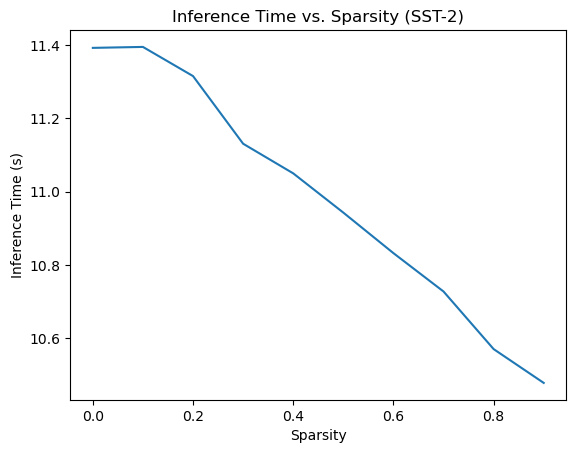

In [30]:
import matplotlib.pyplot as plt
plt.plot(pruning_rates[:10], list(time_all.values())[:10])
plt.xlabel('Sparsity')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time vs. Sparsity (SST-2)')
plt.savefig("Time v Pruning Sparsity (SST-2).png")

In [9]:
accuracy_all = {}
actual_sparsity_all = {}
time_all = {}
pruning_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for pruning_rate in pruning_rates:

    # Load configuration and tokenizer
    model_dir = "/pub/gautamb1/cs295/checkpoints/bert_prune_qqp_" + str(pruning_rate)
    if (pruning_rate == 0.0):
        model_dir = "/pub/gautamb1/cs295/checkpoints/bert_finetuned_qqp"
    config = BertConfig.from_pretrained(model_dir)
    tokenizer = BertTokenizer.from_pretrained(model_dir)
    
    num_classes = 2  
    task='qqp'
    model = BertCustomHead(config, num_classes, task_type='sequence_classification')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state_dict_path = os.path.join(model_dir, 'pytorch_model.bin')
    state_dict = torch.load(state_dict_path, map_location=device) #Dont map it to CPU if ur using a GPU!!!
    model.load_state_dict(state_dict)
    model.to(device)
    
    # Load dataset and tokenizer
    dataset = load_dataset("glue", task)
    metric = load_metric("glue", task, trust_remote_code=True)  # Use evaluate library in future
    
    # Preprocessing function
    def preprocess_function(examples):
        return tokenizer(examples["question1"], examples["question2"], padding="max_length", truncation=True)
    
    # Tokenize the dataset
    encoded_dataset = dataset['validation'].map(preprocess_function, batched=True)
    encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    
    # Prepare DataLoader
    batch_size = 32
    QQP_validation_dataset = encoded_dataset
    QQP_validation_dataloader = DataLoader(QQP_validation_dataset, batch_size=batch_size)
    print(QQP_validation_dataloader.dataset)
    actual_sparsity = calcSparsity(model)
    actual_sparsity_all[pruning_rate] = actual_sparsity
    
    accuracy, time_all[pruning_rate]  = evaluate_model_hf(model, QQP_validation_dataloader, device)
    accuracy_all[pruning_rate] = accuracy
    print(f"Accuracy of the model: {accuracy:.4f}")

Dataset({
    features: ['question1', 'question2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 40430
})
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
Accuracy of the model: 0.7459
Dataset({
    features: ['question1', 'question2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 40430
})
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
Accuracy of the model: 0.7465
Dataset({
    features: ['question1', 'question2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 40430
})
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
Accuracy of the model: 0.7453
Dataset({
    features: ['question1', 'question2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 40430
})
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
Accuracy of the model: 0.7442
Dataset({
    features: ['question1', 'question2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention

Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40430/40430 [00:26<00:00, 1518.66 examples/s]


Dataset({
    features: ['question1', 'question2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 40430
})
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
Accuracy of the model: 0.3682


Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40430/40430 [00:26<00:00, 1527.48 examples/s]


Dataset({
    features: ['question1', 'question2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 40430
})
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
Accuracy of the model: 0.3682
Dataset({
    features: ['question1', 'question2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 40430
})
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
Accuracy of the model: 0.3682


In [10]:
import pickle
with open('qqp_attribution.pickle', 'wb') as handle:
    pickle.dump(accuracy_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
with open('qqp_attribution.pickle', 'rb') as handle:
    b = pickle.load(handle)

print(b)

{0.0: 0.7459312391788276, 0.1: 0.7465001236705416, 0.2: 0.7452881523621073, 0.3: 0.7441503833786792, 0.4: 0.7342567400445213, 0.5: 0.6959683403413307, 0.6: 0.718995795201583, 0.7: 0.5826119218402177, 0.8: 0.36816720257234725, 0.9: 0.36816720257234725, 1.0: 0.36816720257234725}


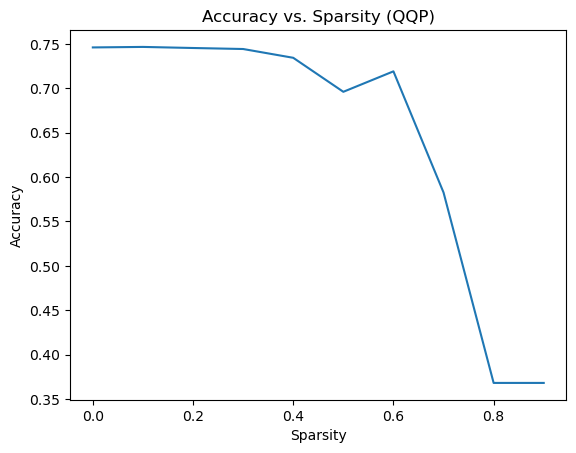

In [15]:
import matplotlib.pyplot as plt
plt.plot(pruning_rates[:10], list(accuracy_all.values())[:10])
plt.xlabel('Sparsity')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Sparsity (QQP)')
plt.savefig("Accuracy v Pruning Sparsity_qqp.png")

Text(0.5, 1.0, 'Accuracy vs. Sparsity (QQP)')

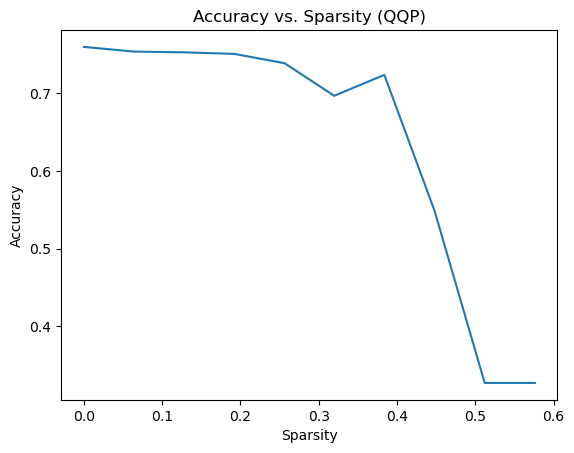

In [16]:
import matplotlib.pyplot as plt
plt.plot(list(actual_sparsity_all.values())[:10], list(accuracy_all.values())[:10])
plt.xlabel('Sparsity')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Sparsity (QQP)')
# plt.savefig("Accuracy v Actual Sparsity (QQP).png")

In [12]:
for name, param in model.named_parameters():
    print(name)
    print(param)

bert.embeddings.word_embeddings.weight
Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0047, -0.0164, -0.0182,  ...,  0.0041,  0.0139, -0.0137],
        [ 0.0113, -0.0097,  0.0192,  ..., -0.0208, -0.0240,  0.0299],
        ...,
        [-0.0142, -0.0028,  0.0167,  ...,  0.0038, -0.0107, -0.0419],
        [-0.0197, -0.0017,  0.0084,  ..., -0.0123,  0.0288, -0.0058],
        [ 0.0075, -0.0149, -0.0099,  ...,  0.0175,  0.0047,  0.0099]],
       requires_grad=True)
bert.embeddings.position_embeddings.weight
Parameter containing:
tensor([[-0.0220, -0.0151,  0.0217,  ...,  0.0248, -0.0110, -0.0002],
        [ 0.0091, -0.0312, -0.0148,  ..., -0.0094,  0.0204, -0.0132],
        [ 0.0229,  0.0124, -0.0169,  ..., -0.0277,  0.0201, -0.0087],
        ...,
        [ 0.0171,  0.0225, -0.0009,  ..., -0.0102,  0.0452,  0.0280],
        [ 0.0277, -0.0217, -0.0073,  ..., -0.0141,  0.0145, -0.0137],
        [ 0.0041,  0.0278,  0.0211,  ..., -0.0194,